# Preparando ambiente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

# Importando dados

In [2]:
df_bev = pd.read_parquet('../data/03_primary/bev_resale_database.parquet')

# Preprocessamento

In [3]:
def remove_outlier(
    df: pd.DataFrame,
    column: str,
    upper_only: bool = False,
    return_outlier: bool = False
) -> pd.DataFrame:
    """
    Remove outlier pelo método de distância interquatílica.
    Se return_outlier for True, retorna apenas outliers da série.
    """

    # Intervalo interquartil
    p25 = df[column].quantile(0.25)
    p75 = df[column].quantile(0.75)
    iqr = p75 - p25

    # Limites inferior e superior
    lower = p25 - 1.5 * iqr
    upper = p75 + 1.5 * iqr
    if upper_only:
        if return_outlier:
            return df[(df[column] > upper)]
        else:
            return df[(df[column] <= upper)]
    else:
        if return_outlier:
            return df[(df[column] < lower) | (df[column] > upper)]
        else:
            return df[(df[column] >= lower) & (df[column] <= upper)]

In [4]:
# Removendo outliers
df_bev_wo_outlier = remove_outlier(df_bev, 'SALE_PRICE', upper_only=True)
df_bev_wo_outlier = df_bev_wo_outlier[df_bev_wo_outlier['SALE_PRICE'] > df_bev_wo_outlier['SALE_PRICE'].quantile(0.01)]
df_bev_wo_outlier = remove_outlier(df_bev_wo_outlier, 'ODOMETER_READING')

# Linhas removidas
print(((df_bev.shape[0] - df_bev_wo_outlier.shape[0]) / df_bev.shape[0]) * 100, '%')
print(df_bev_wo_outlier.shape[0], df_bev.shape[0])

# Selecionando colunas
df_bev_wo_outlier = df_bev_wo_outlier[['CAR_AGE', 'SALE_MONTH', 'ELECTRIC_RANGE', 'MAKE', 'SALE_PRICE']]

6.717171717171717 %
27705 29700


In [5]:
# for c in df_bev_wo_outlier.columns:
#     if (c != 'TRANSACTION_TYPE'):
#         sns.lineplot(data=df_bev_wo_outlier, x=c, y='SALE_PRICE', hue='TRANSACTION_TYPE', palette='pastel')
#         plt.show()

# Regressao

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error ,mean_absolute_percentage_error

preprocess = ColumnTransformer(
        transformers=[
            ('categorical', OrdinalEncoder(), make_column_selector(dtype_include=object)),
            ('numerical', StandardScaler(), make_column_selector(dtype_exclude=object))
        ]
)

clustering_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('cluster', GaussianMixture(n_components=4, init_params="kmeans", random_state=42))
    ]
)

regression_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('regression', RandomForestRegressor(random_state=42))
    ]
)

search_grid = {
    'regression__bootstrap': [True, False],
    'regression__max_depth': np.linspace(10,100,10).astype(int),
    'regression__max_features': ['log2', 'sqrt'],
    'regression__min_samples_leaf': np.linspace(1, 10, 10).astype(int),
    'regression__min_samples_split': np.linspace(2, 10, 5).astype(int),
    'regression__n_estimators': np.linspace(100, 1000, 10).astype(int)
}

regression = RandomizedSearchCV(regression_pipeline, search_grid, n_jobs=6, n_iter=10, random_state=42)

In [7]:
X = df_bev_wo_outlier.drop('SALE_PRICE', axis=1)
y = df_bev_wo_outlier['SALE_PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cluster_cols = ['CAR_AGE', 'ELECTRIC_RANGE']
clustering_pipeline.fit(X_train[cluster_cols])

X_train['CLUSTER'] = clustering_pipeline.predict(X_train[cluster_cols])
X_test['CLUSTER'] = clustering_pipeline.predict(X_test[cluster_cols])

In [8]:
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

print('R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

R2: 0.9078014178083312
MAE: 3715.027668905328
MAPE: 0.18568050678776088


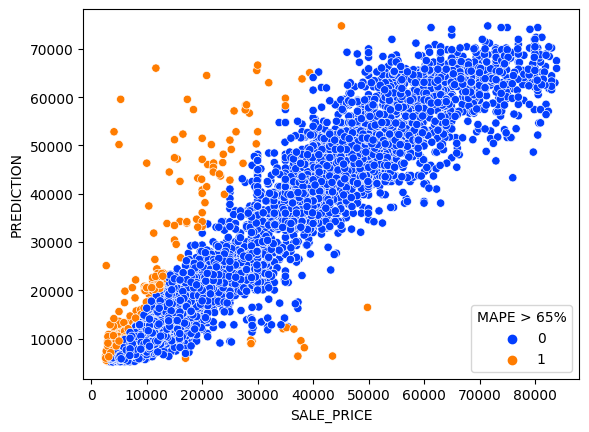

In [22]:
df_pred = pd.concat([X_test, y_test], axis=1)
df_pred['PREDICTION'] = y_pred
df_pred['OUTLIER'] = np.where(
    abs(df_pred['PREDICTION'] - df_pred['SALE_PRICE'])/df_pred['SALE_PRICE'] > .65,
    1,
    0
)

sns.scatterplot(data=df_pred, x='SALE_PRICE', y='PREDICTION', hue='OUTLIER', palette="bright")
plt.legend(title= "MAPE > 65%")
plt.show()